# Recommending audible books for drivers and commuters stuck in traffic in Metro Manila
**MSDS2020**<br>
Chua and Gacera

## Executive Summary

Metro Manila is one of the most congested cities in the world. Its 13 million population is squeezed into just 620 square kilometers, a density of more than 21,000 inhabitants per one kilometer of living space. This has led to a traffic problem that has one expat describing Metro Manila “unlivable” because of the traffic situation. According to a traffic study conducted by Boston Consulting Group (BCG) for ride-hailing platform Uber in 2016, the average Filipino is stuck in traffic an hour and six minutes (66 minutes) a day, equivalent to 16 days of lost productivity time per year. This translates to a staggering 100,000 pesos in lost income per year. It will be difficult to solve the traffic situation given the limited resources available but what could be done in the short term is to provide options to people stuck in traffic on how to be productive. One of the suggested ways to make this time “lost” in traffic is for them to listen to audible books. Books that will help commuters expand their knowledge, hence make their commute more productive. <br>

This study focuses on the Amazon Book Reviews dataset available in the AWS Open Data website (https://registry.opendata.aws/amazon-reviews/), which was downloaded into an AWS S3 bucket. More specifically, this study aims to explore the Books category of Amazon found in (`s3://amazon-reviews-pds/parquet/product_category=Books/`) Initially, Exploratory Data Analysis was performed on the dataset for evaluation and preparation for applying Machine learning models - Frequent Itemset and Association Rule Mining. A Recommender System for Audible Books specifically targeted for commuters is intended to be the final output of the project.

### Keywords

Big Data, Recommender Systems, Frequent Itemset Analysis, Amazon Product Review Dataset, Metro Manila traffic, Audible books, Productivity. 

## 1. Introduction

To go from one place to another, a person needs to commute either by private car or public transport in order to reach his or her destination. This is an essential part of being a member of society. The problem faced by most individuals, especially those living in Metro Manila, is that it takes too long to arrive in the desired location because of the worsening traffic situation. A minimum of 1 hour and 6 minutes is lost because of the daily commute. This unproductive time can be regained by listening to audible books while driving or riding public transport. Amazon.com offers books that are converted into audible versions and this online library can be accessed via subscription. <br>

The Amazon book reviews used in this study will provide insights as to what can be converted into audible formats for consumption of commuters. This recommender system could assist Amazon to identify which books are appropriate for conversion to audio specifically targeted for those individuals who make the daily commute.

## 2. Initialization

## 2a. Collection and description of Amazon Review Data from AWS Open website

The Amazon Review dataset contains product reviews of products and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2015. <br>

This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs). <br>

The specific dataset for books contains the customer review text with accompanying metadata, consisting of three major components: <br>

1.	A collection of reviews written in the Amazon.com marketplace and associated metadata from 1995 until 2015. This is intended to facilitate study into the properties (and the evolution) of customer reviews potentially including how people evaluate and express their experiences with respect to products at scale. (130M+ customer reviews) <br>


2.	A collection of reviews about products in multiple languages from different Amazon marketplaces, intended to facilitate analysis of customers’ perception of the same products and wider consumer preferences across languages and countries. (200K+ customer reviews in 5 countries) <br>


3.	A collection of reviews that have been identified as non-compliant with respect to Amazon policies. This is intended to provide a reference dataset for research on detecting promotional or biased reviews. (several thousand customer reviews). This part of the dataset is distributed separately and is available upon request – please contact the email address below if you are interested in obtaining this dataset. <br>

## 2b. Create dask cluster

First, we create a dask cluster to handle the processing of our data. We used Amazon Web Service EC2 instances: 1 `c5nlarge` for scheduler and `4 c5.xlarge` for the workers. We ran the workers with the argument `--nprocs 2` to create a total of `8 workers`.

In [1]:
from dask.distributed import Client
client = Client('54.249.32.110:8786')
client

Client Scheduler: tcp://54.249.32.110:8786 Dashboard: http://54.249.32.110:8080/status,Cluster Workers: 8 Cores: 16 Memory: 31.98 GB


## 2c. Read Amazon Reviews on books to dask parquet

The parquet files were copied into an `Amazon Elastic File System (EFS)` which was mounted to all the `efs` folders of the instances for faster processing.

In [2]:
!ls /home/ubuntu/efs

part-00000-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00001-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00002-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00003-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00004-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00005-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00006-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00007-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00008-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
part-00009-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet


In [3]:
import dask.dataframe as dd
reviews_raw = dd.read_parquet('/home/ubuntu/efs/*.parquet')

There are 90 total partitions for the dask dataframe.

In [4]:
reviews_raw.npartitions

90

In [5]:
reviews_raw.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'star_rating', 'helpful_votes',
       'total_votes', 'vine', 'verified_purchase', 'review_headline',
       'review_body', 'review_date', 'year'],
      dtype='object')

In [6]:
reviews_raw.head(2)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
0,US,15444933,R1WWG70WK9VUCH,1848192576,835940987,Standing Qigong for Health and Martial Arts - ...,5,9,10,N,Y,Informative AND interesting!,"After attending a few Qigong classes, I wanted...",2015-05-02,2015
1,US,20595117,R1EQ3POS0RIOD5,145162445X,574044348,A Universe from Nothing: Why There Is Somethin...,4,4,7,N,N,Between 'Nothing' and 'Nothing' somehow we are...,Krauss traces the remarkable transformation in...,2012-06-29,2012


The Attributes of our dataset with a brief description of each is shown below: <br>

* `marketplace`: 2-letter country code.
* `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
* `review_id`: A unique ID for the review.
* `product_id`: The Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN> links to the product's detail page.
* `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
* `product_title`: Title description of the product (in this case, book title).
* `star_rating`: The review's rating (1 to 5 stars).
* `helpful_votes`: Number of helpful votes for the review.
* `total_votes`: Number of total votes the review received.
* `vine`: Was the review written as part of the Vine program? (Y/N)
* `verified_purchase`: Was the review from a verified purchase? (Y/N)
* `review_headline`: The title of the review itself.
* `review_body`: The text of the review.
* `review_date`: The date the review was written.
* `year`: The year the review was written.

## 3. Exploratory Data Analysis and Insights

We perform Exploratory Data Analysis on our dataset. We first check the number of transactions/reviews that have missing values.

In [7]:
reviews_raw.isna().sum().compute()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       66
review_body          189
review_date            0
year                   0
dtype: int64

We drop those reviews without any headline and body.

In [45]:
df = reviews_raw.dropna()

We import libraries for plotting and manipulation of our dataframe.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100
import numpy as np
import pandas as pd

## 3a. By marketplace

We first explore the dataset by marketplace. We perform a groupby operation by 'marketplace' and 'customer_id' dropping all the duplicates.

### 3a1. By unique customer_id

In [10]:
df_mp_ci = df[['marketplace', 'customer_id']].drop_duplicates().groupby('marketplace').size().compute()
df_mp_ci

marketplace
DE      51881
FR      16633
JP       8623
UK     188380
US    7963777
dtype: int64

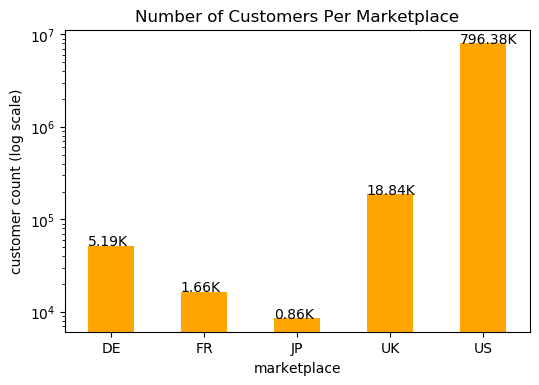

In [106]:
ax = df_mp_ci.plot.bar(color='orange')
ax.set_xlabel('marketplace')
ax.xaxis.set_tick_params(rotation=0)
ax.set_yscale('log')
ax.set_ylabel('customer count (log scale)')
ax.set_title('Number of Customers Per Marketplace');
for i, v in enumerate(df_mp_ci):
    ax.text(i-0.25, v, f'{v/10**4:.2f}K')

As seen from the bar graph, the US market has the most number of customers accounting for more than 96% (796,380 buyers) (822.93) of the total number of unique buyers in the Amazon Marketplace. This if followed by the UK with just around 2.3%. 

### 3a2. By unique product_id

We then look at the data by products.

In [14]:
df_mp_pi = df[['marketplace', 'product_id']].drop_duplicates().groupby('marketplace').size().compute()
df_mp_pi

marketplace
DE       7826
FR       5416
JP       4755
UK      12107
US    3417183
dtype: int64

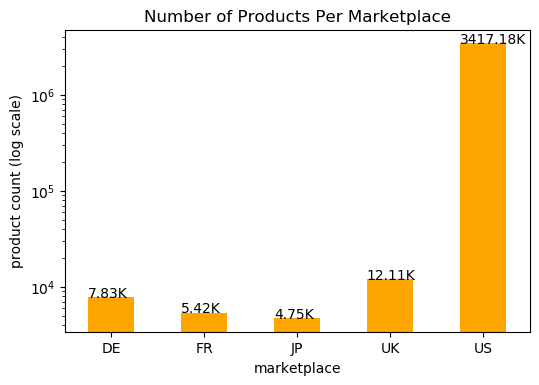

In [107]:
ax = df_mp_pi.plot.bar(color='orange')
ax.set_xlabel('marketplace')
ax.xaxis.set_tick_params(rotation=0)
ax.set_yscale('log')
ax.set_ylabel('product count (log scale)')
ax.set_title('Number of Products Per Marketplace');
for i, v in enumerate(df_mp_pi):
    ax.text(i-0.25, v, f'{v/10**3:.2f}K')

Again, the United States marketplace has the most number of products sold in the platform with 3,417,183 unique products, followed by the UK then Germany.

### 3a3. By number of  transactions

We also explore the data by the number of transactions in each marketplace.

In [16]:
df_mp = df[['marketplace']].groupby('marketplace').size().compute()
df_mp

marketplace
DE       63860
FR       21462
JP       12651
UK      258056
US    20369876
dtype: int64

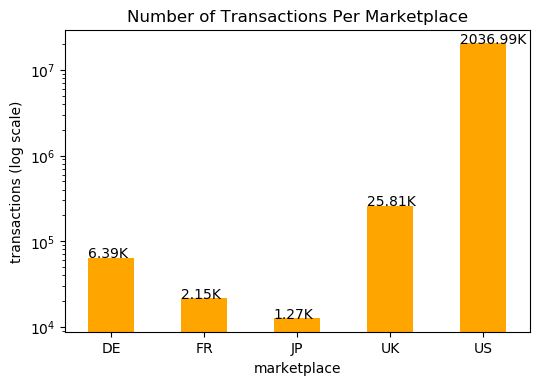

In [109]:
ax = df_mp.plot.bar(color='orange')
ax.set_xlabel('marketplace')
ax.xaxis.set_tick_params(rotation=0)
ax.set_yscale('log')
ax.set_ylabel('transactions (log scale)')
ax.set_title('Number of Transactions Per Marketplace');
for i, v in enumerate(df_mp):
    ax.text(i-0.25, v, f'{v/10**4:.2f}K')

Amazon's home market dominates the platform in number of transactions with over 20,369,876 followed by the UK with 258,056.

### 3a4. We explore the dataset with the combination of unique users, transactions and products.

In [45]:
df_mp_all = df_mp_pi.reset_index(name='product_id'
                             ).merge(df_mp_ci.reset_index(name='customer_id')
                             ).merge(df_mp.reset_index(name='transactions')).set_index('marketplace')
df_mp_all

,product_id,customer_id,transactions
marketplace,,,
DE,7826,51881,63860
FR,5416,16633,21462
JP,4755,8623,12651
UK,12107,188380,258056
US,3417183,7963777,20369876


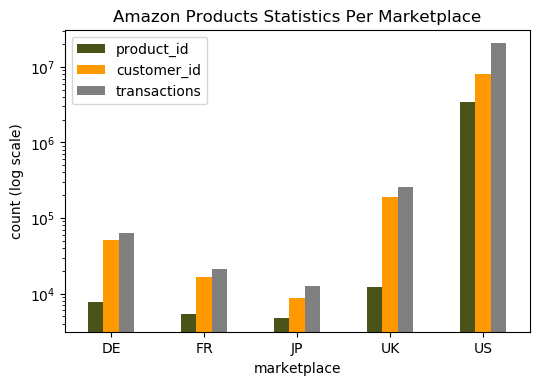

In [181]:
ax = df_mp_all.plot.bar(color=['#4A5418', '#ff9900', 'gray'])
ax.set_xlabel('marketplace')
ax.xaxis.set_tick_params(rotation=0)
ax.set_yscale('log')
ax.set_ylabel('count (log scale)')
ax.set_title('Amazon Products Statistics Per Marketplace');

As shown in the graphs above, Amazon U.S. has the most number of users, products and transactions. United Kingdom is the next largest marketplace for books.

## 3b. Exploratory Data Analysis on the All product dataset

### 3b1. By Ratings

We look at the distribution of ratings for all products. Ratings range from 1 being the lowest to 5 being the highest. A five star rating means that that the rater found the product and service by the seller highly satisfactory.

In [47]:
df_r = df[['star_rating']].groupby('star_rating').size().compute()
df_r

star_rating
1     1112209
2      861852
3     1543592
4     3546289
5    13661963
dtype: int64

In [87]:
for i, v in enumerate(df_r):
    print(i,v, np.log(v))

0 1112209 13.921858685772632
1 861852 13.666838841169275
2 1543592 14.249622725942354
3 3546289 15.08141226257733
4 13661963 16.430126106028425


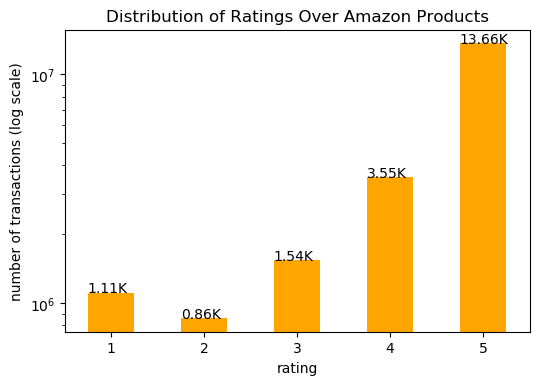

In [96]:
ax = df_r.plot.bar(color='orange')
ax.set_xlabel('rating')
ax.xaxis.set_tick_params(rotation=0)
ax.set_yscale('log')
ax.set_ylabel('number of transactions (log scale)')
ax.set_title('Distribution of Ratings Over Amazon Products');
for i, v in enumerate(df_r):
    ax.text(i-0.25, v, f'{v/10**6:.2f}K')

There are more than 13,661,963 transactions rated with 5 stars, the most compared to all the other ratings of transactions combined. The least number of ratings are 2-stars.

## 3b2. By year average ratings

Average ratings per year was tracked from 1995 to 2015.

In [106]:
df_y_r_mean = df[['year', 'star_rating']].groupby('year')['star_rating'].mean().compute()
df_y_r_mean = df_y_r_mean.sort_index()
df_y_r_mean

year
1995    4.611374
1996    4.613455
1997    4.434137
1998    4.301399
1999    4.217687
2000    4.244497
2001    4.203350
2002    4.170407
2003    4.135401
2004    4.115660
2005    4.147805
2006    4.195074
2007    4.258465
2008    4.229765
2009    4.244171
2010    4.244639
2011    4.248479
2012    4.306624
2013    4.410012
2014    4.472029
2015    4.496298
Name: star_rating, dtype: float64

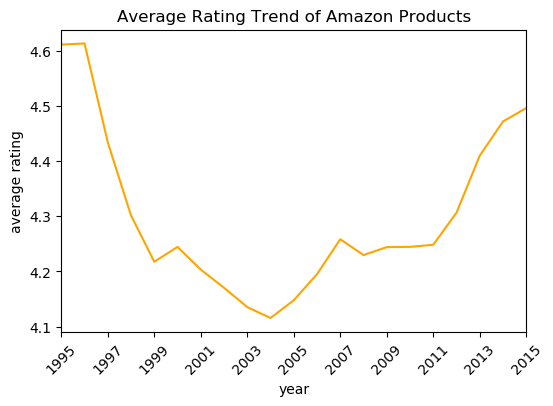

In [120]:
ax = df_y_r_mean.plot(color='orange')
ax.set_xlabel('year')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('average rating')
ax.set_title('Average Rating Trend of Amazon Products');

In [108]:
df_y_r_mean_us = df[df.marketplace=='US'][['year', 'star_rating']].groupby('year')['star_rating'].mean().compute()
df_y_r_mean_us = df_y_r_mean_us.sort_index()

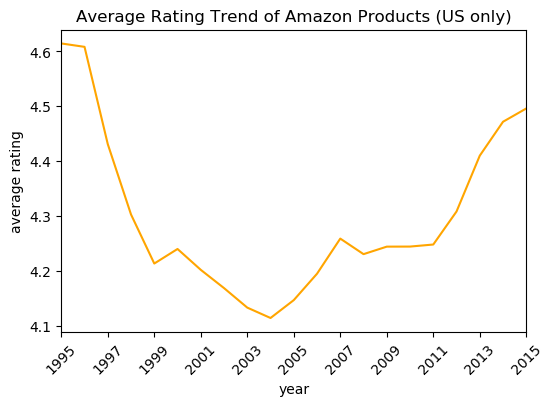

In [121]:
ax = df_y_r_mean_us.plot(color='orange')
ax.set_xlabel('year')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('average rating')
ax.set_title('Average Rating Trend of Amazon Products (US only)');

**Note: same trend since majorityof the products are from US.** <br>

As shown in the two line graphs, the trend for average ratings per year is relatively the same for the U.S. and the International Market. It is interesting to note that in the first year of Amazon it received the highest average rating for its products. It went lower after the first year until 2004 but afterwards the trend became positive with 2015 achieving an average of 4.5 stars near the peak average of above 4.6 stars during its first year. 


### 3b3. Ratings given per year

The trend of the number of ratings per year was also examined.

In [109]:
df_y_r = df[['year', 'star_rating']].groupby('year').size().compute()
df_y_r = df_y_r.sort_index()

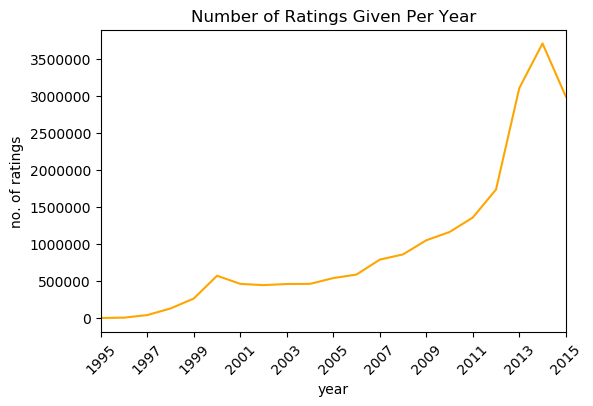

In [122]:
ax = df_y_r.plot(color='orange')
ax.set_xlabel('year')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('no. of ratings')
ax.set_title('Number of Ratings Given Per Year');

The number of ratings given per year steadily increased from 1995 to 2011, afterwards there was a sharp increase in the number of feedback given in the Amazon marketplace. This could be attributed to the rise in internet usage and general openness of people to give feedback.

### 3b4. Customers a year (unique)

The same trend could be seen with the number of unique customers in Amazon. A steady increase from 1995 to 2011 then a sharp rise starting 2012.

In [110]:
df_y_ci = df[['year', 'customer_id']].drop_duplicates().groupby('year').size().compute()

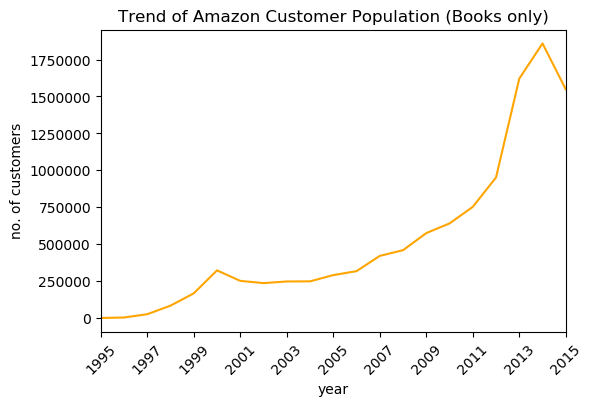

In [123]:
ax = df_y_ci.plot(color='orange')
ax.set_xlabel('year')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('no. of customers')
ax.set_title('Trend of Amazon Customer Population (Books only)');

### 3b5. Products per year (unique)

Trend is also similar to both unique users and unique products.

In [111]:
df_y_pi = df[['year', 'product_id']].drop_duplicates().groupby('year').size().compute()

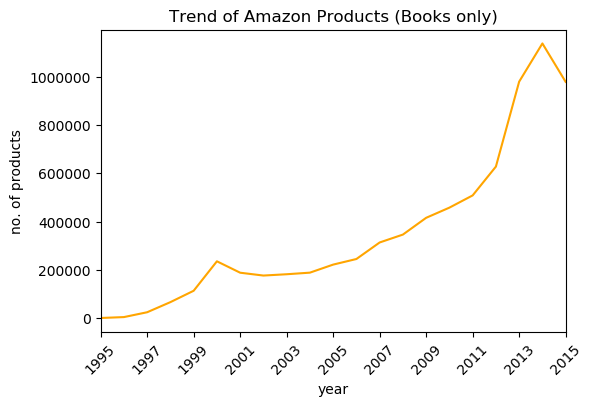

In [124]:
ax = df_y_pi.plot(color='orange')
ax.set_xlabel('year')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('no. of products')
ax.set_title('Trend of Amazon Products (Books only)');

In [112]:
df_y_all = df_y_pi.reset_index(name='product_id'
                              ).merge(df_y_ci.reset_index(name='customer_id')
                              ).merge(df_y_r.reset_index(name='ratings given')).set_index('year')

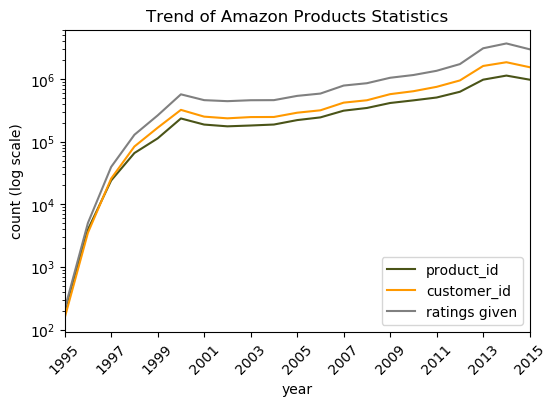

In [125]:
ax = df_y_all.plot(color=['#4A5418', '#ff9900', 'gray'])
ax.set_xlabel('year')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_yscale('log')
ax.set_ylabel('count (log scale)')
ax.set_title('Trend of Amazon Products Statistics');

The graph shown above shows the general trend of the expansion of Amazon throughout the years.

## 3c. By month Exploratory Data Analysis

In [46]:
df['month'] = df['review_date'].dt.month

### 3c1. Ratings per month

In [27]:
df_m_r = df[['month', 'star_rating']].groupby('month').size().compute()
df_m_r = df_m_r.sort_index()
df_m_r

month
1     2059049
2     1771000
3     1842955
4     1667132
5     1696448
6     1679160
7     1866817
8     1907460
9     1480327
10    1526890
11    1479424
12    1749243
dtype: int64

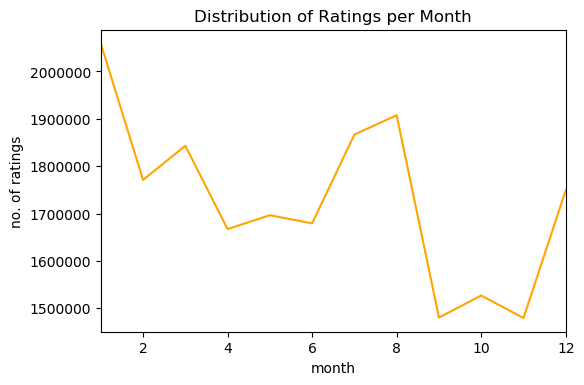

In [37]:
ax = df_m_r.plot(color='orange')
ax.set_xlabel('month')
ax.set_ylabel('no. of ratings')
ax.set_title('Distribution of Ratings per Month');

Most number of ratings were given during the month of January. This is consistent with the fact that the most number of transactions happen during the holiday season.

### 3d. Yearly ratings count

In [64]:
df_y_r_all = df[['year', 'star_rating']].groupby(['year', 'star_rating']).size().compute()

In [127]:
df_y_r_all = df_y_r_all.reset_index(name='count').sort_values(['star_rating', 'year'])

### Ratings per year

In [128]:
df1 = df_y_r_all[df_y_r_all.star_rating==1][['year', 'count']]
df2 = df_y_r_all[df_y_r_all.star_rating==2][['year', 'count']]
df3 = df_y_r_all[df_y_r_all.star_rating==3][['year', 'count']]
df4 = df_y_r_all[df_y_r_all.star_rating==4][['year', 'count']]
df5 = df_y_r_all[df_y_r_all.star_rating==5][['year', 'count']]

In [129]:
df_ra_all = df1.merge(df2, on='year').merge(df3, on='year').merge(df4, on='year').merge(df5, on='year').set_index('year')
df_ra_all.columns = [1,2,3,4,5]

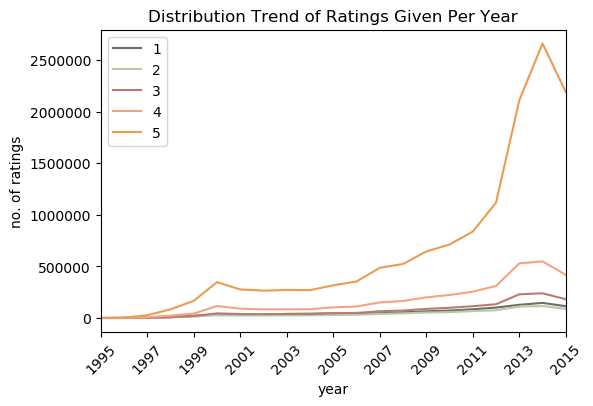

In [146]:
ax = df_ra_all.plot(color=['#697060', '#BAC9A9', '#BA7A74', '#F6A27F', '#EB9C4D'])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end+1, 2))
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('no. of ratings')
ax.set_title('Distribution Trend of Ratings Given Per Year');

The distribution of ratings per year can be seen in the graph above. 5 star ratings consistently appear the most throughtout the years. This shows that a majority of Amazon customers are satisfied with their product and service.

## 4. Acknowledgements
Prof. Chris Alis, Prof. Madhavi Devaraj, Prof. Eduardo David and the entire Asian Institute of Management MS Data Science Faculty